In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
%matplotlib inline


In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [26]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import graph_learning_utils as gl

# Rewrite objective, no derivative

## generate data and include validation matrix

In [8]:
n = 20
ground_truth_asymm = np.random.uniform(0, 0.5, (n, n))
ground_truth_mat = ground_truth_asymm + ground_truth_asymm.T


In [11]:
m = 10
sample_mats = [gen_sample_mat(ground_truth_mat) for _ in range(m)]

In [12]:
sample_mats = [ground_truth_mat] + sample_mats

In [13]:
len(sample_mats)

11

In [20]:
objective = lambda eta_arr: objective_with_params(eta_arr, ground_truth_mat, sample_mats, 0.00, verbose=False)
eta_init = generate_random_eta(len(sample_mats))

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    constraints={'type': 'eq', 'fun': simplex_constraint},
    options={
        'maxiter': 10000,
        'disp': False
    }
)

In [19]:
result

     fun: 2.8299731788466823e-13
     jac: array([-16.91944445,  16.57588705,  18.68839856,  18.24605905,
        19.01201065,  16.50272445,  18.95990419,  15.38300123,
        19.23569889,  18.41013059,  18.77537233])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([1.00000000e+00, 6.67521594e-15, 4.26048086e-15, 2.91433544e-15,
       0.00000000e+00, 0.00000000e+00, 6.28663788e-15, 0.00000000e+00,
       0.00000000e+00, 9.96425165e-15, 9.43689571e-16])

Good! Now we actually get the correct answer. Now let's try the G1/G2 thing.

## g1/g2 idea

In [57]:
eigenbasis_matrix = scipy.stats.ortho_group.rvs(20)
mat1 = eigenbasis_matrix @ np.diag([1.0] + [0.1 for _ in range(19)]) @ eigenbasis_matrix.T
mat2 = eigenbasis_matrix @ np.diag([0.1, 1.0] + [0.1 for _ in range(18)]) @ eigenbasis_matrix.T
mat = 0.5 * mat1 + 0.5 * mat2

In [58]:
scipy.linalg.eigh(mat, eigvals_only=True)

array([0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.55, 0.55])

### feed both mat1, mat2 as sample matrices

In [ ]:
sample_mats = [mat1, mat2]
eta_init = gl.generate_random_eta(len(sample_mats))

result = gl.run_scipy_minimize(
    eta_init, sample_mats, mat, delta=0.0)

In [10]:
result

     fun: 2.7652180549008792e-08
     jac: array([-0.10000001, -1.00000001])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.49999997, 0.50000003])

### feed imbalanced samples but still mat1, mat2

In [33]:
sample_mats = [0.4 * mat1, 0.4 * mat1, mat2]
eta_init = gl.generate_random_eta(len(sample_mats))

objective = lambda eta_arr: objective_with_params(eta_arr, mat, sample_mats, 0.00, verbose=False)

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    # constraints={'type': 'eq', 'fun': simplex_constraint},
    options={
        'maxiter': 10000,
        'disp': False
    }
)

In [34]:
result

     fun: 4.829025313912432e-06
     jac: array([0.36, 0.36, 2.7 ])
 message: 'Optimization terminated successfully'
    nfev: 89
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.5150449 , 0.73494956, 0.50000129])

In [35]:
gl.matrix_lin_combo_pos_sign(result.x, sample_mats) - mat

array([[-6.78820248e-08, -4.29936120e-08, -2.49047208e-08,
         5.09630475e-08, -3.91332124e-08, -6.44322122e-08,
         8.83739366e-08, -4.96923956e-08,  1.16650303e-08,
        -7.41901264e-08,  2.67643965e-08,  9.07758937e-09,
        -6.03572462e-08, -3.45987898e-08, -2.51671211e-08,
         6.51933859e-09, -8.23713208e-09,  1.93058463e-09,
        -3.96718532e-08,  5.78303372e-08],
       [-4.29936120e-08, -3.54082657e-08, -1.53090045e-08,
        -3.02605372e-08,  6.65391429e-08,  3.14982918e-08,
        -1.54015849e-07,  8.03318736e-08, -1.75668262e-08,
         9.49597175e-08, -6.24491268e-08,  3.92620190e-08,
         6.47482832e-09,  8.66055452e-09,  2.85117811e-08,
        -4.24971497e-08, -5.37707028e-08,  4.99594546e-08,
         5.11867649e-08, -6.89927378e-08],
       [-2.49047208e-08, -1.53090045e-08, -2.71368192e-07,
         1.50208510e-07,  3.59235897e-08, -2.13521059e-07,
        -9.42304343e-08,  3.10805353e-08, -2.78747519e-09,
        -4.08386035e-08, -8.3

### balance the coefficients, 1.0 constraint

In [40]:
sample_mats = [0.4 * mat1, 0.6 * mat1, mat2]
eta_init = gl.generate_random_eta(len(sample_mats))

objective = lambda eta_arr: objective_with_params(eta_arr, mat, sample_mats, 0.00, verbose=False)

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    # constraints={'type': 'eq', 'fun': simplex_constraint},
    options={
        'maxiter': 10000,
        'disp': False
    }
)

In [41]:
result

     fun: 1.0529541583447067e-06
     jac: array([-1.15999999, -1.73999999, -2.9       ])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.70890059, 0.3607322 , 0.50000017])

In [42]:
scipy.linalg.svdvals(gl.matrix_lin_combo_pos_sign(result.x, sample_mats) - mat)

array([4.29771134e-07, 1.25838164e-07, 2.76302700e-08, 2.76302700e-08,
       2.76302700e-08, 2.76302700e-08, 2.76302700e-08, 2.76302700e-08,
       2.76302700e-08, 2.76302700e-08, 2.76302700e-08, 2.76302700e-08,
       2.76302700e-08, 2.76302700e-08, 2.76302700e-08, 2.76302700e-08,
       2.76302700e-08, 2.76302700e-08, 2.76302700e-08, 2.76302700e-08])

Takeaway: When we remove the constraint of summing eta_i to 1.0, we see better performance. 
I would speculate that this is mainly a scaling issue - if we allow arbitrary [0,1] scaling of the validation matrix this should go away.

# algo with scaling A^s as well

In [69]:
def objective_with_params_scale_x0(eta_arr, validation_mat, 
        sample_mats, delta, num_eigs_included=None, verbose=False):
    if verbose:
        print(eta_arr)
    if num_eigs_included is None:
        num_eigs_included = validation_mat.shape[0]

    # eta_1, ..., eta_m are the weights for the P_i
    P_hat = matrix_lin_combo_pos_sign(eta_arr[1:], sample_mats)

    # singular values, decreasing order
    diff_sing_values = scipy.linalg.svdvals(eta_arr[0] * validation_mat - P_hat)

    def ob_fn(k): 
        return sum(diff_sing_values[:k]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]
    max_obj_index = np.argmax(all_obj_values)

    return all_obj_values[max_obj_index]

def run_scipy_minimize_with_x0(eta_init, sample_mats, validation_mat, delta, 
        num_eigs_included=None, verbose=False):
    objective = lambda eta_arr: objective_with_params(eta_arr, validation_mat, sample_mats, 0.00, verbose=False)

    # constraints=None
    # if simplex_constraint: 
    #     constraints = {'type': 'eq', 'fun': simplex_constraint}
    
    result = scipy.optimize.minimize(
        objective,
        eta_init,
        method='SLSQP',
        jac=None,
        bounds=[(0.1, 1)] + [(0, 1) for _ in range(len(sample_mats))],
        options={
            'maxiter': 10000,
            'disp': False
        }
    )
    return result


## run with scaling constraint

In [85]:
eigenbasis_matrix = scipy.stats.ortho_group.rvs(20)
mat1 = eigenbasis_matrix @ np.diag([1.0] +
                                   [0.1 for _ in range(19)]) @ eigenbasis_matrix.T
mat2 = eigenbasis_matrix @ np.diag([0.1, 1.0] +
                                   [0.1 for _ in range(18)]) @ eigenbasis_matrix.T
mat = 0.5 * mat1 + 0.5 * mat2


In [86]:
sample_mats = [0.4 * mat1, 0.2 * mat1, mat2]
eta_init = gl.generate_random_eta(len(sample_mats) + 1)
objective = lambda eta: objective_with_params_scale_x0(eta, mat, sample_mats, delta=0.00)

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
    bounds=[(0.1, 1)] + [(0, 1) for _ in range(len(sample_mats))],
    options={
        'maxiter': 10000,
        'disp': False
    }
)

## test that the algo learns k directions, with a parameter k 

* Dial in the parameter that tracks num_eigs_included

In [130]:
max(1, 2)

2

In [132]:
def objective_with_params_fix_x0(eta_arr, validation_mat, 
        sample_mats, delta, num_eigs_included=None, verbose=False):
    if num_eigs_included is None:
        num_eigs_included = validation_mat.shape[0]

    # eta_1, ..., eta_m are the weights for the P_i
    P_hat = matrix_lin_combo_pos_sign(eta_arr, sample_mats)

    # singular values, decreasing order
    diff_sing_values = scipy.linalg.svdvals(validation_mat - P_hat)

    def ob_fn(k): 
        return sum([max(singval - delta, 0.0) for singval in diff_sing_values[:k]])
        # return sum(diff_sing_values[:k]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]
    max_obj_index = np.argmax(all_obj_values)
    if verbose:
        print('max_obj_index at eta = ', eta_arr, ' is ', max_obj_index)
        print('diff sing values at eta = ', eta_arr, ' is ', diff_sing_values)

    return all_obj_values[max_obj_index]

In [133]:
def run_scipy_minimize_no_simplex_constraint(eta_init, sample_mats, validation_mat, delta, 
    num_eigs_included=None, verbose=False, max_iter=10000):
    '''
    eta_init: initial eta vector, len = len(sample_mats)
    '''
    objective = lambda eta_arr: objective_with_params_fix_x0(eta_arr, 
        validation_mat, sample_mats, delta, num_eigs_included=num_eigs_included, 
        verbose=verbose)
    assert len(eta_init) == len(sample_mats), 'eta_init and sample_mats must have the same length'
    
    result = scipy.optimize.minimize(
        objective,
        eta_init,
        method='SLSQP',
        jac=None,
        bounds=[(0, 1) for _ in range(len(sample_mats))],
        options={
            'maxiter': max_iter,
            'disp': verbose
        }
    )
    return result

In [105]:
n = 20
eigenbasis_matrix = scipy.stats.ortho_group.rvs(n)
mat1 = eigenbasis_matrix @ np.diag(np.linspace(0, 1, n)) @ eigenbasis_matrix.T
mat2 = eigenbasis_matrix @ np.diag(np.linspace(3, 4, n)) @ eigenbasis_matrix.T
mat = 0.5 * mat1 + 0.5 * mat2

In [110]:
sample_mats = [0.4 * mat1, 0.2 * mat1, mat2]

In [140]:
true_mat_svals = np.copy(scipy.linalg.svdvals(mat))

In [141]:
true_mat_svals

array([2.5       , 2.44736842, 2.39473684, 2.34210526, 2.28947368,
       2.23684211, 2.18421053, 2.13157895, 2.07894737, 2.02631579,
       1.97368421, 1.92105263, 1.86842105, 1.81578947, 1.76315789,
       1.71052632, 1.65789474, 1.60526316, 1.55263158, 1.5       ])

In [150]:
true_loss_vals = []
recorded_loss_vals = []
# delta_range = np.linspace(0, 3.0, 20)
for k in range(1, 21): 
    avg_true_loss = 0.0
    avg_recorded_loss = 0.0
    for _ in range(100): 
        eta_init = gl.generate_random_eta(len(sample_mats))
        result = run_scipy_minimize_no_simplex_constraint(eta_init, sample_mats, mat, num_eigs_included=k,
            delta=0.0, verbose=False)
        eta_result = result['x']
        diff_mat = mat - matrix_lin_combo_pos_sign(eta_result, sample_mats)
        diff_sing_values = scipy.linalg.svdvals(diff_mat)
        avg_true_loss += sum(diff_sing_values)
        avg_recorded_loss += result['fun']
    true_loss_vals.append(avg_true_loss / 100.0)
    recorded_loss_vals.append(avg_recorded_loss / 100.0)
    print(k)
    # sum_sing_values = sum(diff_sing_values)
    # true_loss_vals.append(sum_sing_values)
    # recorded_loss_vals.append(result['fun'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


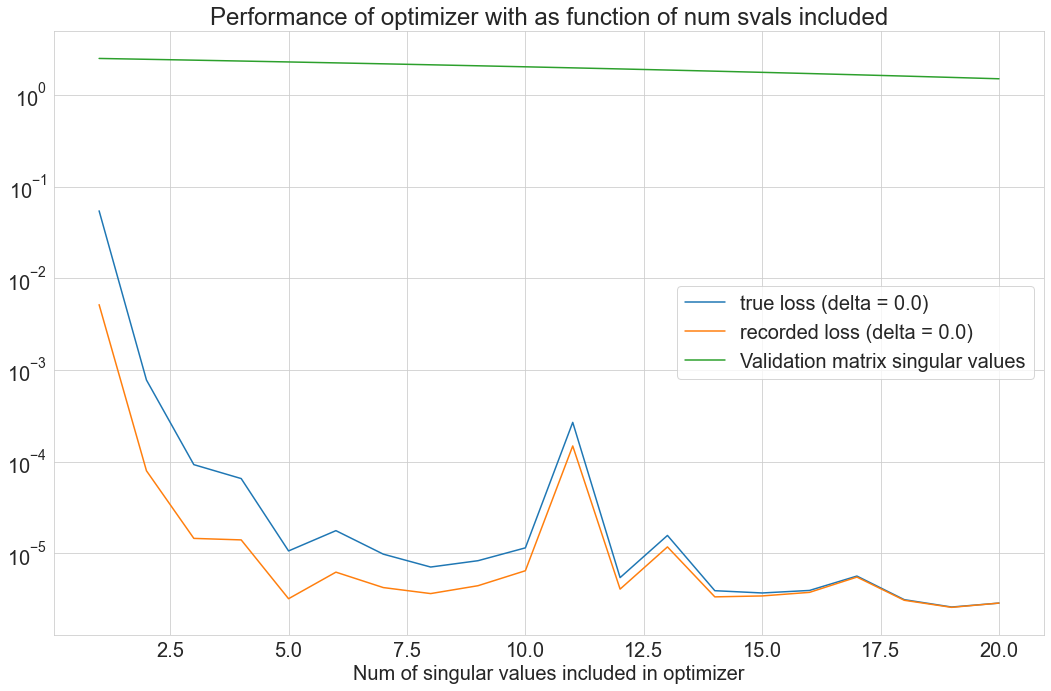

In [155]:
plt.plot(1 + np.arange(20), true_loss_vals, label='true loss (delta = 0.0)')
plt.plot(1 + np.arange(20), recorded_loss_vals, label='recorded loss (delta = 0.0)')
plt.plot(1 + np.arange(20), true_mat_svals, label='Validation matrix singular values')
plt.legend()
plt.yscale('log')
plt.xlabel('Num of singular values included in optimizer')
plt.title('Performance of optimizer with as function of num svals included');
plt.tight_layout()
plt.savefig('figs/optimizer_performance_vs_num_svals_included.png', dpi=300)

## performance vs delta

In [162]:
true_loss_vals = []
recorded_loss_vals = []
delta_range = np.linspace(0, 3.0, 10)
for d in delta_range: 
    avg_true_loss = 0.0
    avg_recorded_loss = 0.0
    for _ in range(100): 
        eta_init = gl.generate_random_eta(len(sample_mats))
        result = run_scipy_minimize_no_simplex_constraint(eta_init, sample_mats, mat, d, verbose=False)
        eta_result = result['x']
        diff_mat = mat - matrix_lin_combo_pos_sign(eta_result, sample_mats)
        diff_sing_values = scipy.linalg.svdvals(diff_mat)
        sum_sing_values = sum(diff_sing_values)
        avg_true_loss += sum_sing_values
        avg_recorded_loss += result['fun']
    true_loss_vals.append(avg_true_loss / 100.0)
    recorded_loss_vals.append(avg_recorded_loss / 100.0)

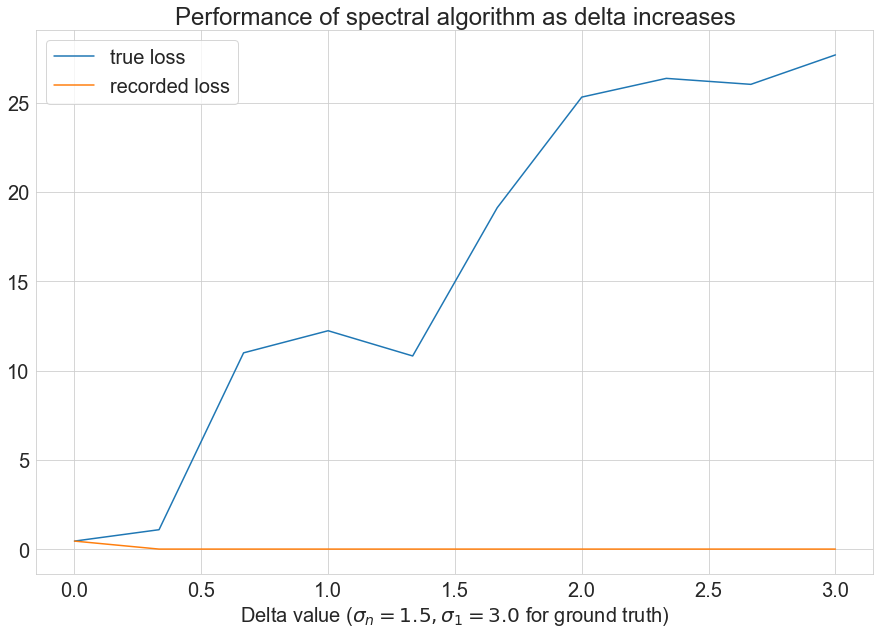

In [165]:
# delta_range = np.linspace(0, 3, 30)
plt.plot(delta_range, true_loss_vals, label='true loss')
plt.plot(delta_range, recorded_loss_vals, label='recorded loss')
plt.legend()
plt.xlabel('Delta value ($\sigma_n = 1.5, \sigma_1 = 3.0$ for ground truth)')
# plt.yscale('log')
plt.title('Performance of spectral algorithm as delta increases')
plt.savefig('figs/spectral_algorithm_delta_performance.png', dpi=300)

## Another test: include 2 eigenvalues but then add a third eigenvalue to the ground truth

Through our G1 and G2 idea, we've already shown that we can recover a linear combination that gets the right eigenvalues. 

Now, we want to show a failure mode for this approach. In particular, the delta parameter controls the accuracy of the algorithm. If we set it high enough, it should fail to recover eigenvalues below a certain threshold. 

Indeed, this is exactly what we did above, no? 

In [156]:
true_loss_vals = []
recorded_loss_vals = []
delta_range = [0, 1, 2, 3]


In [157]:
n = 20
eigenbasis_matrix = scipy.stats.ortho_group.rvs(n)
mat1 = eigenbasis_matrix @ np.diag(np.linspace(0, 1, n)) @ eigenbasis_matrix.T
mat2 = eigenbasis_matrix @ np.diag(np.linspace(3, 4, n)) @ eigenbasis_matrix.T
mat = 0.5 * mat1 + 0.5 * mat2

sample_mats = [0.1 * mat1, 0.3 * mat1, 0.5 * mat2, 0.2 * mat2]

In [160]:
true_loss_vals = []
recorded_loss_vals = []
# delta_range = np.linspace(0, 3.0, 20)
for d in delta_range:
    avg_true_loss = 0.0
    avg_recorded_loss = 0.0
    for _ in range(100): 
        eta_init = gl.generate_random_eta(len(sample_mats))
        result = run_scipy_minimize_no_simplex_constraint(eta_init, sample_mats, mat, num_eigs_included=20,
            delta=d, verbose=False)
        eta_result = result['x']
        diff_mat = mat - matrix_lin_combo_pos_sign(eta_result, sample_mats)
        diff_sing_values = scipy.linalg.svdvals(diff_mat)
        avg_true_loss += sum(diff_sing_values)
        avg_recorded_loss += result['fun']
    true_loss_vals.append(avg_true_loss / 100.0)
    recorded_loss_vals.append(avg_recorded_loss / 100.0)
    print(k)

20
20
20
20


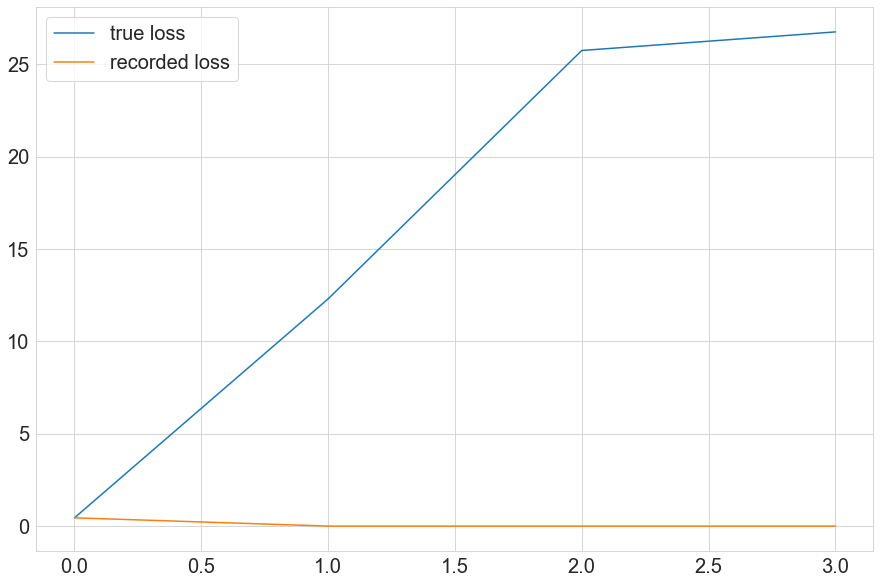

In [161]:
plt.plot(delta_range, true_loss_vals, label='true loss')
plt.plot(delta_range, recorded_loss_vals, label='recorded loss')
plt.legend()